## Load all the scripts
Here, all the modules are called using the _import-ipynb_ librairy. To install, use command :
``` python
!pip install import-ipynb 
```

This imports all the functions to this notebook

In [34]:
#load all the functions from other scripts
import import_ipynb
%run IP/IP_methods.ipynb #Image processing script
%run PathPlanning.ipynb # Path Planning script


## Constants

In [41]:
RADIUS = 30 #thymio radius 95 mm between the wheels
EPSILON_PATH_PLANNING = 5 #
#A0 size 841 x 1188 mm
XSIZE = 2*841
YSIZE = 1188
desired_size=[XSIZE, YSIZE]

plot = True
verbose = False

## Hyperparameters for Vision and Path Planning

In [47]:
#different path usefull locations
Path_to_MAP = 'output'

smoothing_factor= 0.01 # smoothing factor
csvPath = Path_to_MAP + "/obst.csv"
savePath = Path_to_MAP + "/csvIM.png"

goalPath = Path_to_MAP + "/goal.csv"
goalsavePath = Path_to_MAP + "/csvIM_goal.png"

graph_name = Path_to_MAP + '/graph'

In [ ]:
(x,y), orientation = pipeline_IP(plot)
start = [x,y]

100%|██████████| 6/6 [00:00<00:00, 37.84it/s]


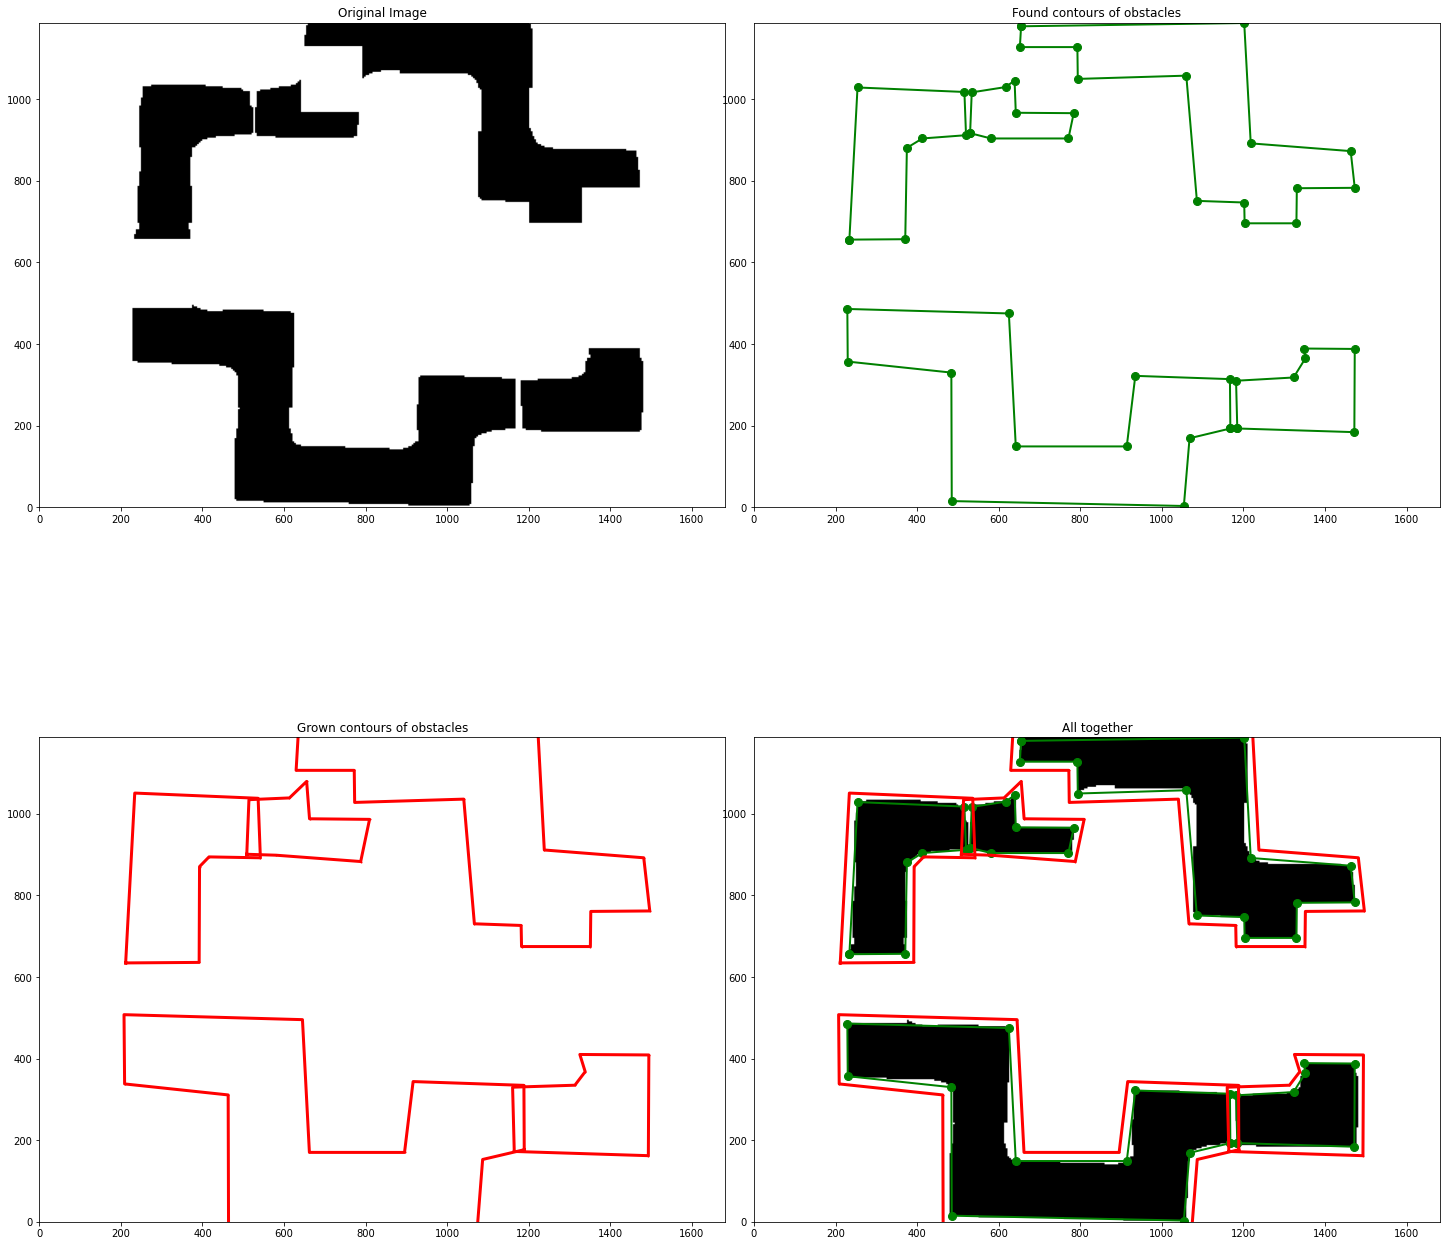

In [48]:
goal = PathPlanning_offline(graph_name, csvPath, savePath, goalPath, goalsavePath, desired_size, 
                         smoothing_factor, RADIUS, EPSILON_PATH_PLANNING, plot, verbose)

Hi

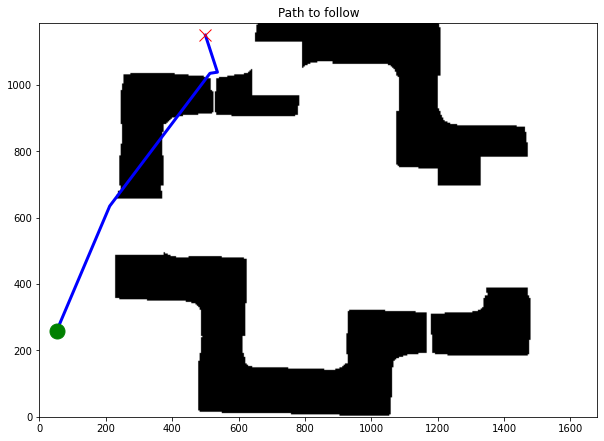

In [57]:
goal = [500, 1150]
path, inObstacle = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, plot)